In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import pandas_datareader.data as web
from datetime import datetime
from pandas import Series, DataFrame
from scipy import stats
from patsy import dmatrices
from sklearn import datasets, svm
import statsmodels.graphics.api as smg
import matplotlib 
%matplotlib inline
matplotlib.style.use('bmh')

### 1. 学习理解如何用最小二乘法的矩阵公式来得到线性回归的解，并使用 numpy 库来实现该算法

#### (1) 最小二乘法的矩阵公式

- 先从简单的线性方程开始 y=ax+e，为了使 a 的存在有意义，我们想要尽量减小误差 error 的值，这时可以把公式化为矩阵形式来求解 $$y⃗ =Xa⃗ +e⃗$$
- 经过转化，可以得到最小二乘的矩阵公式( 这里X为一个矩阵，y为一个向量 ) ：$$ a⃗ =(XᵀX)⁻¹Xᵀy⃗  $$ 
- 矩阵求解的过程可以由 numpy的最小二乘函数解决

#### (2) 数据
用到是有关儿童心理中侵略性表现的一组数据，用线性回归来分析各变量对侵略性表现的影响

In [4]:
data = pd.read_csv('aggression.csv')
data.tail(3)

,caseid,Healthy_diet,Permissive_parenting,Sibling_aggression,Television,computer_games,Aggression
147,148,6,47.843846,26,104.609894,43.756800,24
148,149,6,60.555113,22,104.951786,40.374633,21
149,150,1,29.665106,23,96.410949,37.123673,26


#### (3) 用 numpy 库来最小二乘法矩阵公式解线性回归问题
创建 np arrays 和 矩阵：
- 取作为自变量的 Healthy_diet、Permissive_parenting、Sibling_aggression、Television、computer_games 建立线性回归 等式右边的 X 矩阵

In [5]:
X = np.array(data.iloc[:, [1,2,3,4,5]])
X[:5]

array([[   3.        ,   37.20966087,   17.        ,  103.4534107 ,
          42.83813373],
       [   4.        ,   27.51833456,   26.        ,   99.34256315,
          54.19836443],
       [   5.        ,   36.71937026,   18.        ,   98.51079589,
          32.19718887],
       [   3.        ,   29.94880692,   20.        ,   99.91146737,
          31.83839281],
       [   5.        ,   44.89477816,   11.        ,   86.4952262 ,
          34.4444439 ]])

- 选取需要被解释的 Aggression 为因变量

In [6]:
y = np.array(data['Aggression'])
y[:5]

array([24, 28, 19, 20, 17])

#### (4) numpy 线性回归
1. 用 numpy 中的 linalg.lstsq 实现最小二乘解线性回归

In [7]:
coefficient = np.linalg.lstsq(X, y)[0]
coefficient

array([-0.28215255,  0.04421313,  0.05487823,  0.12809786,  0.14022893])

In [ ]:
2. 依据最小二乘法的矩阵公式求解 a⃗ =(XᵀX)⁻¹Xᵀy⃗ ，结果与最小二乘函数的计算结果吻合

In [11]:
np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))

array([-0.28215255,  0.04421313,  0.05487823,  0.12809786,  0.14022893])

#### (5) 有关儿童侵略性表现的线性回归公式

In [380]:
y = []
for i in range(5):
     y += str(round(list(coefficient)[i],3))+'*'+list(data.columns[1:-1])[i] + ' +',
Aggression = ' '.join(y)
print 'Aggression = ' + Aggression[:-1]

Aggression = -0.282*Healthy_diet + 0.044*Permissive_parenting + 0.055*Sibling_aggression + 0.128*Television + 0.14*computer_games 


---

### 2. 使用 pandas 库中的函数，下载上证综指和任一成份股票数据，建立回归模型，将上证综指的收益率作为解释变量

#### (1) 读取数据
读取中石化 SNP 和上证综指 SSE 过去一年的数据

In [381]:
start = datetime(2015, 6, 18)
end = datetime(2016, 6, 18)
sse = web.DataReader('000001.SS', 'yahoo', start, end)
snp = web.DataReader('SNP', 'yahoo', start, end)
snp.head(3)

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2015-06-18,83.660004,84.709999,83.660004,84.559998,219800,81.679944
2015-06-19,83.779999,84.430000,83.709999,83.820000,164500,80.965150
2015-06-22,84.860001,85.400002,84.739998,84.959999,143900,82.066322


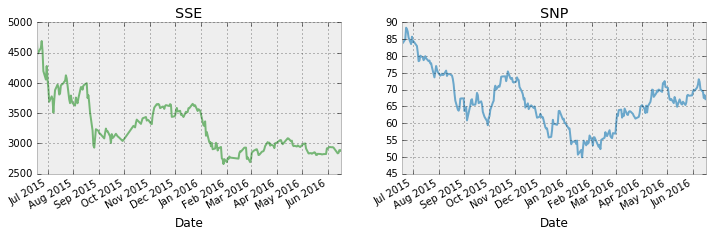

In [382]:
plt.figure(figsize = (12,3))
plt.subplot(121)
sse.Close.plot(color = 'green', alpha = 0.5)
plt.title('SSE')
plt.subplot(122)
snp.Close.plot(alpha = 0.7)
plt.title('SNP')

#### (2) 计算日收益率
对 Close 数值进行错行计算，转化为对数收益率

In [383]:
sse['Return'] = (np.log(sse[1:]) - np.log(sse[:-1].values))['Close']*100
snp['Return'] = (np.log(snp[1:]) - np.log(snp[:-1].values))['Close']*100

#### (3) 简单清理数据，删除缺失值

In [384]:
linear = pd.DataFrame({'SSE':sse['Return'], 'SNP': snp['Return']})
linear = linear.dropna(how='any')
linear.head()

,SNP,SSE
Date,,
2015-06-19,-0.878968,-6.630435
2015-06-23,3.957828,2.167542
2015-06-24,-0.476297,2.453224
2015-06-25,-0.936506,-3.523281
2015-06-26,-1.969942,-7.684629


#### (4) 画图看相关性
从图上可以看出，SNP 和 SSE 的相关性较低

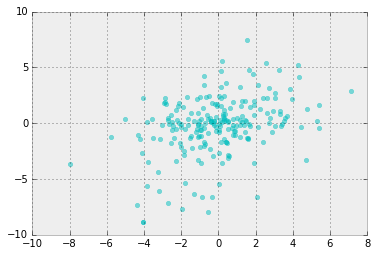

In [385]:
plt.scatter(linear.SNP, linear.SSE, color = 'c', alpha = 0.5)

#### (5) 创建线性回归公式
去掉截距项，以上证综指日收益率为解释变量，以中石化日收益率为因变量

In [386]:
stock_formula =  'SNP ~ -1 + SSE' 
y, x = dmatrices(stock_formula, data=linear, return_type='matrix')

#### (6) 线性回归分析结果
- 自变量 SSE 的相关系数为 **0.331**，且 p 值很小，说明 SSE 的日收益率变化对 SNP 的变化量存在影响
- 但调整后的 R 方 Adj. R-squared 数值很小，只有 **0.134**， 说明除了 SSE，还有重要的影响变量未考虑进来 
- 因此，以上证综指日收益率为自变量，中石化日收益率为因变量建立的回归模型，不足以用来说明中石化的日收益率变化  
但中石化日收益率的变化，会受到上证综指日收益率变化的影响

In [387]:
# 建立线性模型
stock_model = sm.OLS(y, x)
# 拟合 
stock_fit = stock_model.fit()
# 线性回归报告
print(stock_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                    SNP   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     34.67
Date:                Sun, 19 Jun 2016   Prob (F-statistic):           1.46e-08
Time:                        01:48:32   Log-Likelihood:                -473.74
No. Observations:                 219   AIC:                             949.5
Df Residuals:                     218   BIC:                             952.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
SSE            0.3250      0.055      5.888      0.0

---

### 3. 在kaggle网站上找到titanic数据，并使用logistic回归来建模，研究分析每个因素对应生存的重要性

#### (1) 数据读取
- 对数据定义的初步思考：因变量 Survived 为0、1分类变量，这里要分析一个有关是与否的问题，且要考察各因素的重要性，用到逻辑回归。
- 了解各项数据代表什么
    - pclass : Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
    - survival : (0 = No; 1 = Yes)
    - sibsp : Number of Siblings/Spouses Aboard
    - parch : Number of Parents/Children Aboard
    - ticket : Ticket Number
    - fare : Passenger Fare
    - embarked : Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [3]:
train = pd.read_csv("train.csv") 
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### (2) 数据初步总结
1. 样本量为 891，对应 12 个变量
2. Cabin 数据有较多缺失值，重要变量年龄也有一定的缺失值
3. 考虑使用的变量为：是否生还、性别、年龄、船舱、是否与兄妹或父母子女同船、票价与上岸地点

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


#### (3) 简单的数据清理
1. 去掉暂不需要的列    
    - 剔除姓名，乘客编号，船票号和房间号这些对是否生还的影响较小的变量
2. 清理缺失值 :     
    - 问题：这里把 **年龄** 中的缺失值全部转成中位数了，导致的探索分析出现了变化       
    - 分析：
        - 数据中有很多年龄缺失值，但即便年龄值缺失，这些数据仍能说明其他重要的参考变量，如船舱、性别和是否生还
        - 生还年龄段的箱线图出现了变化，中位数虽然不变，但生还年龄集中在靠近中位数的位置了
    - 决定：介于后面的逻辑回归结果，船舱等级、性别和年龄相比，前两者对逻辑回归模型的影响更大，这里仍然保留年龄缺失的行 

In [5]:
train = train.drop(['PassengerId','Name', 'Ticket', 'Cabin'], axis = 1)
train['Age'] = train['Age'].fillna(train['Age'].median())
train= train.dropna(how = 'any')
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [99]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
Survived    889 non-null int64
Pclass      889 non-null int64
Sex         889 non-null object
Age         889 non-null float64
SibSp       889 non-null int64
Parch       889 non-null int64
Fare        889 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


#### (4) 数据初探 － 画图

#### 船舱 Pclass
分船舱看生还情况，从一等舱到三等舱，生还的比率逐渐减小；一等舱和二等舱的生还比差不多，而三等舱生还的比率很小。  
初步从图形上看，船舱等级可以作为生还的一个参考因素来看。

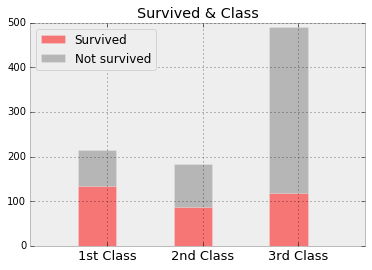

In [100]:
Class = [1, 2, 3]
Class1 = list(train.Pclass[train.Survived == 1].value_counts().sort_index())
Class0 = list(train.Pclass[train.Survived == 0].value_counts().sort_index())
plt.bar(Class, Class1, label = 'Survived', color = 'r', width = 0.4, alpha = 0.5)
plt.bar(Class, Class0, label = 'Not survived', color = 'grey', bottom = Class1, width = 0.4, alpha = 0.5)
plt.title('Survived & Class')
plt.xticks([x + 0.3 for x in Class], ['1st Class', '2nd Class', '3rd Class'], size = 13)
plt.xlim(0.5, 4)
plt.legend(loc=0)

plt.show()

#### 性别 Sex   
- 女性生还人数的比率高于男性，性别也可以作为一个重要参考因素来看    
- 一点思考：看过泰坦尼克号的人可能会记得，逃生时，更多的生存机会被让给了女性。所以，虽然我们能看出更多的女性生还了，但不能直接下结论说，女性具有更多的生还能力。礼让这个信息是摆在数据之外的。这样看，进一步解释数据时，还需要参考数据的相关信息，单看数据本身，分析可能会受到局限。

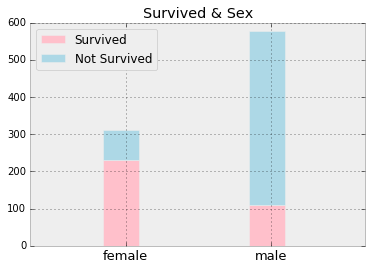

In [101]:
Sex = [0, 1]
Sex0 = list(train.Sex[train.Survived == 0].value_counts().sort_index())
Sex1 = list(train.Sex[train.Survived == 1].value_counts().sort_index())
plt.bar(Sex, Sex1, label='Survived', color = 'pink', width = 0.25)
plt.bar(Sex, Sex0, bottom = Sex1, label='Not Survived',  color = 'lightblue', width = 0.25)
plt.xticks([x+0.155 for x in Sex], ['female', 'male'], size = 13)
plt.xlim(-0.5, 1.8)
plt.title('Survived & Sex')
plt.legend(loc=0)

plt.show()

#### 登船地点 Embarked

- 生还人数 Southampton > Cherbourg > Queenstown
- 生还比率 Cherbourgh > Queenstown > Southampton
- 总人数多的地点，生还人数自然会多一些。例如，从 Southampton 登船的人当中，有很多人活了下来，但 Southampton 总的生还比率不高。     
- 不太能从图形上看出登船地点对生还的影响，即便从常识来推断，登船地点似乎也不是一个重要的影响因素。

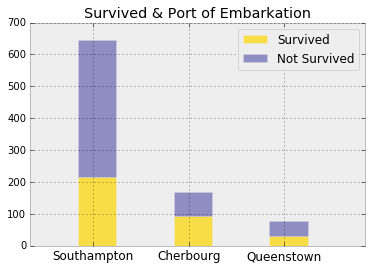

In [102]:
Embarked = [0, 1, 2]
Embarked0 = list(train.Embarked[train.Survived == 0].value_counts())
Embarked1 = list(train.Embarked[train.Survived == 1].value_counts())
plt.bar(Embarked, Embarked1, label='Survived', color = 'gold', alpha = 0.7, width = 0.4)
plt.bar(Embarked, Embarked0, bottom = Embarked1, label='Not Survived',  color = 'navy', alpha = 0.4, width = 0.4)
plt.xticks([x+0.155 for x in Embarked], ['Southampton','Cherbourg', 'Queenstown'], size = 12)
plt.xlim(-0.5, 3)
plt.title('Survived & Port of Embarkation')
plt.legend(loc=0)

plt.show()

#### 年龄
即使船舱不同，但生还的人主要是青壮年

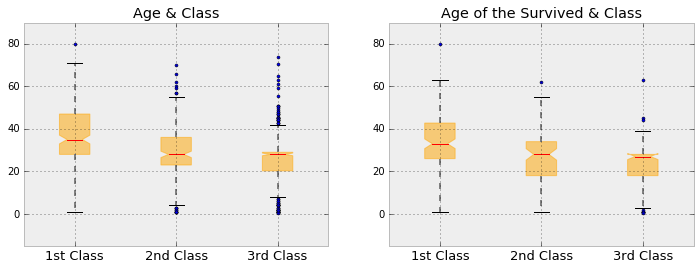

In [103]:
plt.figure(figsize = (12,4))
plt.subplot(121)
Survived_age_class1 = list(train.Age[train.Pclass == 1])
Survived_age_class2 = list(train.Age[train.Pclass == 2])
Survived_age_class3 = list(train.Age[train.Pclass == 3])
box = plt.boxplot([Survived_age_class1, Survived_age_class2, Survived_age_class3], [1,2,3], patch_artist=True)
plt.setp(box['boxes'], color='orange', alpha = 0.5)
plt.setp(box['whiskers'], color='grey', linewidth = 2)
plt.setp(box['fliers'], marker = 'o', markersize = 3)
plt.xticks([x for x in Class], ['1st Class', '2nd Class', '3rd Class'], size = 13)
plt.title('Age & Class')
plt.ylim(-15, 90)

plt.subplot(122)
Survived_age_class1 = list(train.Age[train.Survived == 1][train.Pclass == 1])
Survived_age_class2 = list(train.Age[train.Survived == 1][train.Pclass == 2])
Survived_age_class3 = list(train.Age[train.Survived == 1][train.Pclass == 3])
box = plt.boxplot([Survived_age_class1, Survived_age_class2, Survived_age_class3], [1,2,3], patch_artist=True)
plt.setp(box['boxes'], color='orange', alpha = 0.5)
plt.setp(box['whiskers'], color='grey', linewidth = 2)
plt.setp(box['fliers'], marker = 'o', markersize = 3)
plt.xticks([x for x in Class], ['1st Class', '2nd Class', '3rd Class'], size = 13)
plt.title('Age of the Survived & Class')
plt.ylim(-15, 90)

plt.show()

#### 父母、子女、兄妹、配偶同船情况
单独登船的人，生还比例不是最高的；虽然单独登船的生还人数最多，但主要因为这部分人占总人数比例最大   
另外，从图上看来，在有一到两位家人陪伴的情况下，生还的比例稍大

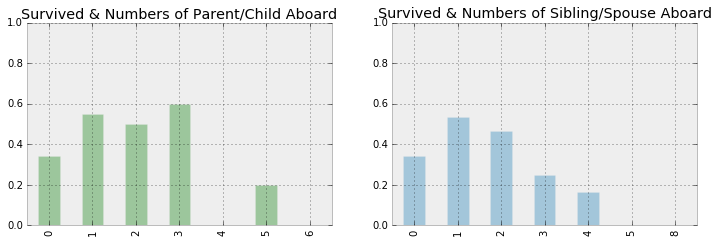

In [104]:
fig = plt.figure(figsize=(12, 8), dpi=900) 

plt.subplot(221)
Pch_survived = train.Parch[train.Survived == 1].value_counts().sort_index()/train.Parch.value_counts().sort_index()
Pch_survived.fillna(0)
Pch_survived.plot.bar(color = 'forestgreen', alpha = 0.4)
plt.title('Survived & Numbers of Parent/Child Aboard')
plt.ylim(0, 1)

plt.subplot(222)
Sib_survived = train.SibSp[train.Survived == 1].value_counts().sort_index()/train.SibSp.value_counts().sort_index()
Sib_survived.fillna(0)
Sib_survived.plot.bar(alpha = 0.4)
plt.title('Survived & Numbers of Sibling/Spouse Aboard')
plt.ylim(0, 1)

plt.show()

#### (4) 逻辑回归
- 通常情况下，逻辑回归用来解答一个二分问题，即因变量可以表示为 0 或 1 。因变量是分类变量，自变量常常为连续变量。
- 简单来说，逻辑回归可以作为一个分类器，若 p > 0.5 可归为 1 类；p < 0.5，可归为 0 类。

#### 泰坦尼克生还案例
那么，分析乘客是否生还的问题也就可以转化为一个逻辑回归问题。
- 第一步可以试着计算每个乘客生还的可能性更容易为 0 或 1。    

- 问题：第一步只显示了生还的可能性，但生还可能性不能说明一个人最后有没有活下来。   
因此，我们需要把可能性转化为二分（ 0 或 1 ）决策。     
- 解决：可以尝试着把生存率超过50%的人划分为生还的那部分人，这时可以考虑逻辑回归。

#### 逻辑回归实现步骤
1. 定义逻辑回归公式    
2. 建立逻辑回归数据框
3. 设置回归模型
4. 拟合
5. 检查残差

#### 每个因素对生存的重要性
1. 先剔除 P 值较大的变量：     
Fare, Parch, Embark，这三个值 P 值较大，说明变量对是否生还的影响很小
2. 再看相关系数，自变量对是否生还的影响排名如下：    
Sex > Class > Numbers of Siblings/Spouse > Age    
影响较大的为性别和船舱等级，兄妹配偶同船的影响相对较弱，年龄对是否生还的影响最弱
3. 模型拟合
    - 线性回归运用最小二乘法，而逻辑回归用到了极大似然估计。进行逻辑回归的时候，其实并不存在一个真正对应的R方来检验逻辑回归模型。逻辑回归模型是依据似然情况而决定的。为了评价逻辑回归的拟合程度，统计学家创造了伪 R 方，伪 R 方的计算公式也较多 [总结表格](http://www.ats.ucla.edu/stat/mult_pkg/faq/general/Psuedo_RSquareds.htm)
    - 伪 R 方看起来和 R 方差不多，取值在 0 到 1 之间，伪 R 方越大表示模型拟合得越好
    - 伪 R 方的 McFadden's 公式：
    - <img src="http://www.ats.ucla.edu/stat/mult_pkg/faq/general/McFadden.jpg" width="47%" height="100%" style="float:left"/>
    
    - Mfull 为模型的似然估计值，Mintercept 为一个假设数值，即模型只受截距影响的可能性。如果一个模型拟合的不好，极大似然值和只受截距影响值的差别不大，两者取对数相除的结果很接近1，而伪 R 方  McFadden's 算式的结果也就很接近 0
    - 下面建立的逻辑回归，其结果的伪 R 方较小，说明拟合的不太好。去掉不显著的变量以后，伪 R 方仍没有较大变化，说明这些自变量还不足以说明其因变量


In [105]:
# 用 pasty dmatrices 函数创建数据框，设置分类变量 C()
logit_formula = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + C(Embarked)+ Fare' 
y, x = dmatrices(logit_formula, data = train, return_type = 'dataframe')

# 设置回归模型
model = sm.Logit(y,x)

# 用训练数据来拟合模型
res = model.fit()

# 显示逻辑回归报告
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.441182
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  889
Model:                          Logit   Df Residuals:                      879
Method:                           MLE   Df Model:                            9
Date:                Sun, 19 Jun 2016   Pseudo R-squ.:                  0.3368
Time:                        19:43:48   Log-Likelihood:                -392.21
converged:                       True   LL-Null:                       -591.41
                                        LLR p-value:                 3.013e-80
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept            4.0625      0.473      8.594      0.000         3.136     4.989
C(Pclass)[T

### 练习

#### (5) 支持向量机 － 当一条直线不足以划分不同类别的时候

#### 逻辑回归遇到的问题
- 回到泰坦尼克号生还案例：   
  如果我们用年龄来预测是否生还，则会得到一个线性判定边界：例如，以年龄为自变量，生还结果为因变量，关于年龄的生还示意图则为一条直线。详细些说，年轻一些的人可能有更多的机会生还。   
  事实上，年龄生还示意图可能是一条曲线 –– 青年人生还的可能性更高，而年幼和年长的人生还的可能性相对较低。    
  值得注意的是，逻辑回归只能估测线性判定边界。处理多维判定边界时，可以考虑支持向量机或决策树。
 
#### 基本思想
- 支持向量机可以把模型转换到不同的数学维度中，来完成逻辑回归不能完成的任务     
- 它的基本思想是，找到一个超平面，来把 N 维数据完美地分割到两个类别之中     
- 👇[关于支持向量机的一个介绍](https://www.zhihu.com/question/21094489)

#### 支持向量机的代码实现
- 数据准备
    - 建立公式，将公式 x，y 两边转为 numpy array
    - 选择用来分析的两个变量，同时 y 值转1维 👇[np.ravel](http://docs.scipy.org/doc/numpy/reference/generated/numpy.ravel.html)
    - 随机排列 x，y 值
    - 设置交叉验证
- 拟合 
    - svm.SVC(kernel, gamma)
    - fit X_train & y_train
    
- [cmap色表](http://matplotlib.org/examples/color/colormaps_reference.html) 

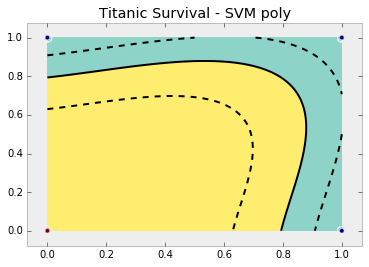

In [106]:
# 设立公式，建立数据框
SVM_formula =  'Survived ~ C(Pclass) + C(Sex) + Age + SibSp' 
y, x = dmatrices(SVM_formula, data=train, return_type='matrix')

# 将公式数据框中的数据放入 numpy array
# 挑选感兴趣的变量来分析:通过刚才的回归分析，已知性别和船舱对是否生还的影响较大，这里选择代表性别 3 和船舱 2 的两列来分析
X = np.asarray(x)
# y 值是这样的数据，array([[ 0.], [ 1.], [ 1.], [ 1.] ...]), 用 np.ravel() 转换为 array([ 0.,  1.,  1.,  1.,  0.,  0., ...])
y = np.asarray(y).ravel()
X = X[:,[2, 3]]  

# 随机排列 x, y值 
np.random.seed(123)
order = np.random.permutation(len(x))
X = X[order]
y = y[order].astype(np.float)

# 做一个交叉验证，前80%的数据用来训练，后20%的数据用来检验
nighty_precent_of_sample = int(.8 * len(x))
X_train = X[:int(.8 * len(x))]
y_train = y[:int(.8 * len(x))]
X_test = X[int(.8 * len(x)):]
y_test = y[int(.8 * len(x)):]

# 拟合
# gamma 参数: 参数 gamma 表示超平面的线性平滑度，当使用线性核函数构建 SVM 时，模型中不存在 gamma 参数。
# 我们知道: gamma 越小，超平面越接近于直线，但是如果 gamma 选取过大，超平面将会变得非常弯曲，这会导致过度拟合问题。
poly = svm.SVC(kernel='poly', gamma=2.5)
poly.fit(X_train, y_train)

plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10)

# 描出训练数据
plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none', zorder=10)
    
plt.axis('tight')
x_min = X[:, 0].min()
x_max = X[:, 0].max()
y_min = X[:, 1].min()
y_max = X[:, 1].max()

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = poly.decision_function(np.c_[XX.ravel(), YY.ravel()])

Z = Z.reshape(XX.shape)
plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Set3)
plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
               levels=[-.5, 0, .5])

plt.title('Titanic Survival - SVM poly')
plt.show()

#### (6) 随机森林

#### 什么是随机森林？   
随机森林会生成很多的决策树，当我们基于某些属性对一个新的对象进行分类判别时，随机森林中的每一棵树都会给出自己的分类选择，并由此进行“投票”，森林整体的输出结果将会是票数最多的分类选项。而在回归问题中，随机森林的输出将会是所有决策树输出的平均值

#### 随机森林算法是如何工作的？在随机森林中，每一个决策树“种植”和“生长”的规则如下所示：     
- 假设我们设定训练集中的样本个数为N，然后通过有重置的重复多次抽样来获得这N个样本，这样的抽样结果将作为我们生成决策树的训练集    
- 如果有M个输入变量，每个节点都将随机选择m(m<M)个特定变量，然后运用这m个变量来确定最佳分裂点。在决策树的生成过程中，m的值是保持不变的    
- 每棵决策树都最大可能地进行生长而不进行剪枝     
- 通过对所有的决策树进行加总来预测新的数据（在分类时采用多数投票，在回归时采用平均）       

.
<img src="http://image.slidesharecdn.com/janvitekdistributedrandomforest5-2-2013-130504133205-phpapp02/95/jan-vitek-distributedrandomforest522013-8-638.jpg?cb=1367674437" width="47%" height="100%" style="float:left"/>

In [107]:
import sklearn.ensemble as ske

# 创建随机森林模型
Forest_formula = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp' 
y, x = dmatrices(Forest_formula, data=train, return_type='dataframe')
# y 转 1 维
y = np.asarray(y).ravel()
# 把数据拟合进拟合模型
results = ske.RandomForestClassifier(n_estimators=100).fit(x, y)

# 显示结果，精确度很理想，为0.9
results.score(x, y)

0.90213723284589431

---

### 4. 搜集某个城市过去 1 个月的 PM2.5 小时级数据，根据时间序列预测方法进行预测

#### (1) 读取和清理数据
- 数据源 http://young-0.com/airquality/  
抽取 5 月一整月的数据，预测 6 月 1 到 5 号的 pm2.5 情况

In [400]:
pm = pd.read_csv('AQIbeijing.csv', header = None)
pm.head()

,0,1,2,3,4
0,day,hour,avg,conc,city
1,01/05/16,0,199,148,0
2,01/05/16,1,199,149,0
3,01/05/16,2,204,154,0
4,01/05/16,3,197,144,0


**时间数据清理**：这里日期与小时数据分开了，清理数据的时候正好复习一遍 datetime
 - 先把时间转成 datetime 认可的形式，再用 strptime 将 string 转为 datetime 形式
 - 注意 pm.date 和 pm['date'] 的区别

In [401]:
pm.columns = pm.iloc[0,:]
pm = pm.drop(0)

pm.date = pm.day + ' ' + pm.hour + ':00:00'
pm['date'] = pm.date.apply(lambda x : datetime.strptime(x, '%d/%m/%y %H:%M:%S'))
pm = pm.set_index('date')

pm['avg'] = pm['avg'].astype(float)
pm = pm[['avg']]

pm.head()

,avg
date,
2016-05-01 00:00:00,199.0
2016-05-01 01:00:00,199.0
2016-05-01 02:00:00,204.0
2016-05-01 03:00:00,197.0
2016-05-01 04:00:00,215.0


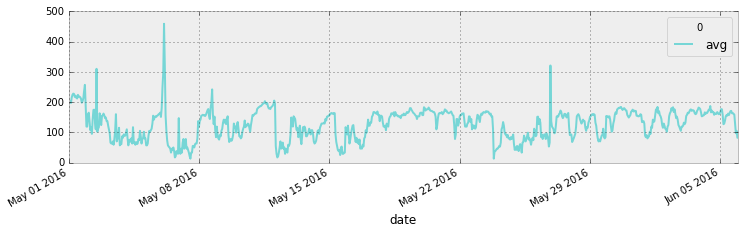

In [402]:
pm.plot(figsize = (12,3), color = 'c', alpha = 0.5)
plt.show()

#### (2) 查看历史数据与未来数据是否自相关
- 间隔 1 小时与间隔 24 小时的自相关情况
    - 间隔 1 小时的自相关性还不错，可以从图上看出相关系数图像接近一条直线
    - 间隔 24 小时的自相关性就不太理想了，图形不呈一条直线

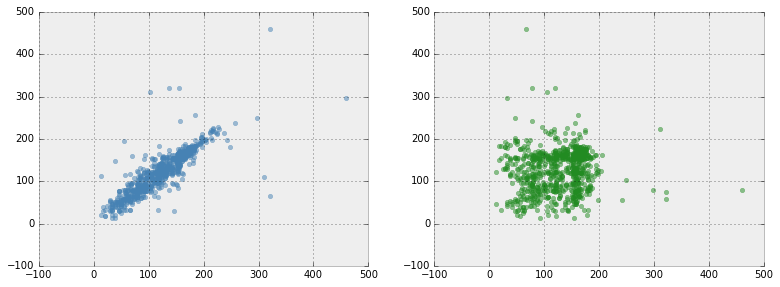

In [403]:
plt.figure(figsize=(13,10))
plt.subplot(221)
plt.scatter(pm[1:], pm[:-1], color = 'steelblue', alpha = 0.5, s = 20)
plt.subplot(222)
plt.scatter(pm[24:], pm[:-24], color = 'forestgreen', alpha = 0.5, s = 20)

#### (3) 求差分
- 做差分是为了保证时间序列的行为不随时间变化而一直改变。平稳性可以看作时间序列的内部逻辑性，即每一期的序列值与前几期之间存在一致的结构性变化关系。满足了平稳性的前提，我们才能建立模型去分析和预测。
- 可从图2看出，做过1阶差分后，pm2.5 的时间序列已比较平稳。

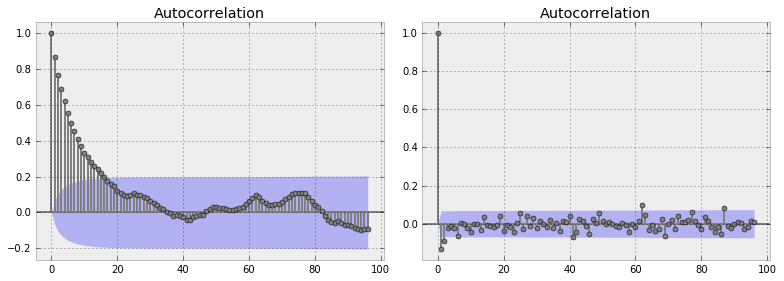

In [404]:
fig, axes = plt.subplots(1, 2, figsize = (11, 4))
smg.tsa.plot_acf(pm.avg, lags = 96, ax = axes[0], color = 'grey')
# 一阶差分
smg.tsa.plot_acf(pm.avg.diff().dropna(), lags = 96, ax = axes[1], color = 'grey')
fig.tight_layout()

#### (4) 建立 AR 自相关回归模型并检验参差
AR模型的实现步骤：
1. 根据时间序列的散点图、自相关函数和偏自相关函数图以ADF单位根检验其方差、趋势及其季节性变化规律，对序列的平稳性进行识别。

2. 对非平稳序列进行平稳化处理。如果数据序列是非平稳的，并存在一定的增长或下降趋势，则需要对数据进行差分处理，如果数据存在异方差，则需对数据进行技术处理，直到处理后的数据的自相关函数值和偏相关函数值无显著地异于零。

3. 根据时间序列模型的识别规则，建立相应的模型。若平稳序列的偏相关函数是截尾的，而自相关函数是拖尾的，可断定序列适合AR模型；若平稳序列的偏相关函数是拖尾的，而自相关函数是截尾的，则可断定序列适合MA模型；若平稳序列的偏相关函数和自相关函数均是拖尾的，则序列适合ARMA模型。

4. 进行参数估计，检验是否具有统计意义。

5. 进行假设检验，诊断残差序列是否为白噪声。
6. 利用已通过检验的模型进行预测分析。

In [405]:
ARmodel = sm.tsa.AR(pm.avg)
ARfit = ARmodel.fit(96)

#### (5) 检验残差，残差不存在自相关性
- 在线性和非线性回归中，我们假设残差是彼此独立的（不相关）。如果违反独立假设，一些模型的拟合结果将会不可靠。例如，误差项之间的正相关往往会放大系数 t 值，从而使预测变量显得重要，而事实上它们可能并不重要。
- 如果 durbin_watson 检测的结果在 1.5 到 2.5 之间，就可以认为残差不存在自相关。
- 检验结果接近 2，结果很理想，残差不存在自相关性。

In [406]:
sm.stats.durbin_watson(ARfit.resid)

2.0001784271042662

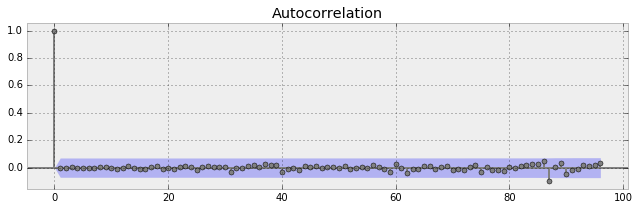

In [407]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3))
smg.tsa.plot_acf(ARfit.resid, lags = 96, color = 'grey', ax = ax)
fig.tight_layout()

#### (6) 时间序列预测
从图上看，预测的 6 月 1 号到 5 号的 pm2.5 数值，结果较理想，预测很贴近真实值

/Users/Q16/anaconda/lib/python2.7/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


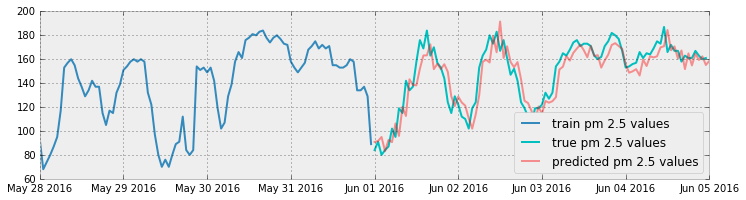

In [408]:
pm_train = pm[pm.index.month == 5]
pm_true = pm[pm.index.month == 6] 

plt.figure(figsize = (12, 3))
plt.plot(pm_train.index.values[-96:], pm_train.avg[-96:], label = 'train pm 2.5 values')
plt.plot(pm_true.index.values[:96], pm_true.values[:96], label = 'true pm 2.5 values', color = 'c')
plt.plot(pd.date_range("2016-06-01", "2016-06-05", freq="H").values,
        ARfit.predict("2016-06-01", "2016-06-05"), label="predicted pm 2.5 values", color = 'r', alpha = 0.4)

plt.legend(loc = 0)
plt.show()

---

### 笔记

#### (1) 线性回归拟合的几种方式
1. np.linalg.lstsq(X, y)
    - 创建 np arrays
    - 构建 np 矩阵 np.vstack([]).T
    - np.linalg.lstsq(X, y)

2. statsmodel - sm.OLS(y, X) Ordinary Least Squares
    - 构建模型 model = sm.OLS(y, X)
    - 拟合 result = model.fit()
    - 显示参数 result.params

3. dataframe 接入 statsmodel 
    - 构造 dataframe
    - 构建回归模型 smf.ols('dependent variabl ~ constant variable + independent variable 1 + independent variable 2 + i1*i2', df)
    - 拟合 result = model.fit
    - 显示参数 result.params
    - ```打印报告 print(result.summary())```

#### (2) 线性回归与 K nearest neighbor ( KNN ) 的比较
1. 对训练数据的态度
    - 线性回归： 训练一些数据，训练后得到一组参数，训练后的数据也就不要了
    - KNN： 历史数据都会留下来，预测时，会参考历史数据
2. 过拟合问题上的不同
    - KNN 的 k 越小，越有可能过拟合；线性回归的 degree 自变量越多，越有可能过拟合
3. 所占空间，计算时间与添加新数据上的不同
    - space for saving model 线性回归只保存拟合后的参数，而 KNN 要留下大量的历史数据
    - time to train the data KNN 不太需要时间去训练数据，而线性回归相对需要更多时间来训练数据
    - time to query KNN 需要时间去排序数据，而线性回归把数据代入简单的方程即可
    - adding new data 线性回归需要重新计算新数据，而 KNN 可把数据直接代入已有数据集

#### (3)  使用 ```patsy.dmatrices()[1].design_info.term_names 快速处理交互项 ```

y ~ -1 + a + b | y ~ a\*b\*c - a:b:c |  y ~ - 1 + C(a)  | y ~ I(a + b) | ```z = lambda y1, y2 : y1*y2``` \ y ~ z(a, b)  | y ~ - 1 + C(a, Poly)  
----|:------:|:----:|:----:|:------:|:----:|:------:|----|----|------|----
 去除截距项 | a, b, c, a:b, b:c, a:c, <s>a:b:c<s>   | 转为分类变量 a :0,1,0  | ['Intercept', 'I(a + b)'] | y ~ z(a, b)  | 转为高次函数 
 

#### (4) 如何解读 regression output
#### 1. R-squared 决定系数    
R^2 越高，模型拟合得越好
#### 2. Intercept 截距项 
截距项不具备太多的解读价值，但如果在回归模型中去除应有的截距项，回归模型可能会产生偏差。一旦去除截距项，模型就不得不经过原点，其斜率也就会受到影响。下图中绿线为去除截距项之后的线性模型：

<img src="http://cdn2.content.compendiumblog.com/uploads/user/458939f4-fe08-4dbc-b271-efca0f5a2682/742d7708-efd3-492c-abff-6044d78e3bbd/Image/ea4e1643bedca51bf7281108b69efdd8/flp_no_constant.gif" width="40%" height="100%" style="float:left"/>

#### 3. 标准误 P>[t]   
在R output中，若一个变量对应很小的 p 值，则意味着可以保留某变量
#### 4. 检测残差   
- z, p = stats.normaltest(result.resid.values)    
如果残差 p 值较小，说明一部分该考虑到的数据不在 x1 和 x2 中，而是留在残差中了，因此，模型需要经过进一步调整。
- Q-Q plot   
若残差数据排成 45 度斜线，符合正态分布

#### 5. 相关系数
result.params 说明各变量在模型中所占的权重

#### (5) 逻辑回归与决策树相比，有什么优势 （摘取自 👇[quora](https://www.quora.com/What-are-the-advantages-of-logistic-regression-over-decision-trees) ）

**1. 决策树的假设**
- 决策树假设我们的决策边界是与坐标轴平行的     
比如说，如果我们有两个特征 x1 和 x2，那么决策树只能产生像 x1 >= 4.5, x2 >= 6.5 这样的边界，如图所示：
<img src="https://qph.ec.quoracdn.net/main-qimg-3190f95e3bd446949131bb7339bd1da4" width="47%" height="100%" style="float:left"/>

- 所以决策树会把特征空间平整地切成句型，或者高纬度的超矩形。切矩形的方法可以有很多种，因此决策树很自然地会创建更复杂的函数，比如说有更高的VC维，这样可能会造成过拟合 

**2. 逻辑回归的假设**
- 逻辑回归会假设一个更平滑灵活的线性决策边界，也就解决了决策树平行于坐标轴的决策边界问题

<img src="https://qph.ec.quoracdn.net/main-qimg-c9d0a05dbf19fb8b1717b6f583aa57c7" width="47%" height="100%" style="float:left"/>



**3. 决策树与逻辑回归的比较**
- **应用**：这两个算法的速度都很快，如果要解决单个决策边界问题，逻辑回归可以很好地完成任务，且能够出平滑的决策边界。而决策树也有它的优势，它能够在解决多个决策边界问题时发挥最佳功效，能够被应用到超矩形区域当中
- **过拟合**：逻辑回归相对简单，变化较少，较不容易产生过拟合问题。而决策树能被划分为复杂的函数，也就容易产生过拟合问题。可以用剪枝算法来解决这一问题
- **结合**：怎样能让决策树保留划分多维决策边界的能力，又不做出平行于坐标轴的决策边界呢 –– 支持向量机